# Stack Exchange Popular Data Science Questions

In this project, we set to pull the most popular data science questions from Stack Exchange by utilizing the Stack Exchange Data Explorer (SEDE).

## Initial SQL Exploration

We begin by exploring the tables within the SEDE. The `Posts` table seems to be the most relevant to our goal of finding the most popular questions. Using the following query, we can see the relevant columns within the table as well as sample rows.

```sql
SELECT TOP 10 *
FROM Posts;
```

<img src="screenshots/Screenshot 2024-12-17 142147.jpg"/>

Running the following gives us an explanation on Post Types:

```sql
SELECT *
FROM PostTypes;
```

<img src="screenshots/Screenshot 2024-12-17 142503.jpg"/>

Seeing this table, we can see that we want to narrow down our posts to the `PostTypeId` of 1 to only view questions.

## Get Relevant Data From `Questions` Post Type

The columns that we are targetting are:
- Id
- PostTypeId
- CreationDate
- Score
- ViewCount
- Tags
- AnswerCount
- FavoriteCount

---

### Questions from 2024

We can filter the Posts table with the necessary columns by `Questions` type with the following query, focusing on only posts that are within the current year (2024):

```sql
SELECT Id, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
FROM Posts
WHERE PostTypeId = 1 AND CreationDate >= '2024-01-01 00:00:00'
ORDER BY CreationDate DESC;
```

<img src="screenshots/Screenshot 2024-12-17 142904.jpg"/>

---

### Dynamic: Questions from last 12 months

We can even convert this into a dynamic query that will pull a years worth of data regardless of the current date.

```sql
SELECT Id, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
FROM Posts
WHERE PostTypeId = 1 AND CreationDate >= DATEADD(MONTH, -12, GETDATE())
ORDER BY CreationDate DESC;
```

<img src="screenshots/Screenshot 2024-12-17 143717.jpg"/>

Using this resulting table, we will download it as a `.csv` and analyze our results further.

## 

## Data Exploration Using Python

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv('2024_questions.csv', parse_dates=['CreationDate'])

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             2082 non-null   int64         
 1   CreationDate   2082 non-null   datetime64[ns]
 2   Score          2082 non-null   int64         
 3   ViewCount      2082 non-null   int64         
 4   Tags           2082 non-null   object        
 5   AnswerCount    2082 non-null   int64         
 6   FavoriteCount  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 114.0+ KB


In [3]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,130937,2024-12-14 19:42:10,0,7,<scikit-learn><random-forest><overfitting><for...,0,NaN
1,130935,2024-12-14 06:21:49,0,10,<neural-network><pytorch><overfitting>,0,NaN
2,130931,2024-12-13 17:58:34,0,54,<scikit-learn><xgboost>,1,NaN
3,130928,2024-12-13 15:36:20,0,12,<python><pytorch><forecasting><attention-mecha...,0,NaN
4,130927,2024-12-13 15:34:17,1,16,<dataset><data-mining><data><visualization><da...,1,NaN


In [4]:
df.isnull().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    2082
dtype: int64

In [5]:
df['FavoriteCount'].value_counts(dropna=False)

FavoriteCount
NaN    2082
Name: count, dtype: int64

In [6]:
df['Tags'].value_counts(dropna=False)

Tags
<machine-learning>                                                17
<deep-learning>                                                    8
<machine-learning><python><deep-learning><neural-network><nlp>     8
<time-series>                                                      7
<dataset>                                                          6
                                                                  ..
<python><bayesian><monte-carlo>                                    1
<machine-learning><time-series><forecasting>                       1
<data-cleaning>                                                    1
<python><xgboost><multiclass-classification>                       1
<machine-learning><time-series><regression>                        1
Name: count, Length: 1856, dtype: int64

### Findings:
- Null values in `FavoriteCount`
    - All values are null in this case
- `Tags` column needs cleaning
    - Change formatting from brackets to comma-separated
    - Store in list

## Data Cleaning

Because all values within `FavoriteCount` are null in this case, we can drop the column within this dataset.

In [7]:
df.drop(columns=['FavoriteCount'], axis=1, inplace=True)

Now we can continue with cleaning the `Tags` column.

In [8]:
df['Tags'].sample(random_state=42)

1366    <nlp><text-classification><automatic-summariza...
Name: Tags, dtype: object

In [9]:
# Clean Tags by removing < > and splitting by ><
def clean_tags(tags):
    return [tag.strip('<>') for tag in tags.split('><')]

df['Tags'] = df['Tags'].apply(clean_tags)

In [10]:
df['Tags'].sample(random_state=42)

1366    [nlp, text-classification, automatic-summariza...
Name: Tags, dtype: object

## Most Used / Most Viewed Posts

In [12]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount
0,130937,2024-12-14 19:42:10,0,7,"[scikit-learn, random-forest, overfitting, for...",0
1,130935,2024-12-14 06:21:49,0,10,"[neural-network, pytorch, overfitting]",0
2,130931,2024-12-13 17:58:34,0,54,"[scikit-learn, xgboost]",1
3,130928,2024-12-13 15:36:20,0,12,"[python, pytorch, forecasting, attention-mecha...",0
4,130927,2024-12-13 15:34:17,1,16,"[dataset, data-mining, data, visualization, da...",1


In [13]:
# Store tag cally count into new dictionary
tag_uses = {}

for tags in df['Tags']:
    for tag in tags:
        if tag in tag_uses:
            tag_uses[tag] += 1
        else:
            tag_uses[tag] = 1

# Create dataframe from dictionary
tag_uses = pd.DataFrame.from_dict(tag_uses, orient='index')
tag_uses.rename(columns={0: 'Uses'}, inplace=True)

In [14]:
# Store tag view count into new dictionary
tag_views = {}

for tags in df['Tags']:
    for tag in tags:
        if tag in tag_views:
            tag_views[tag] += df['ViewCount']
        else:
            tag_views[tag] = df['ViewCount']

# Create dataframe from dictionary
tag_views = pd.DataFrame.from_dict(tag_views, orient='index')
tag_views.rename(columns={0: 'Views'}, inplace=True)

<Axes: >

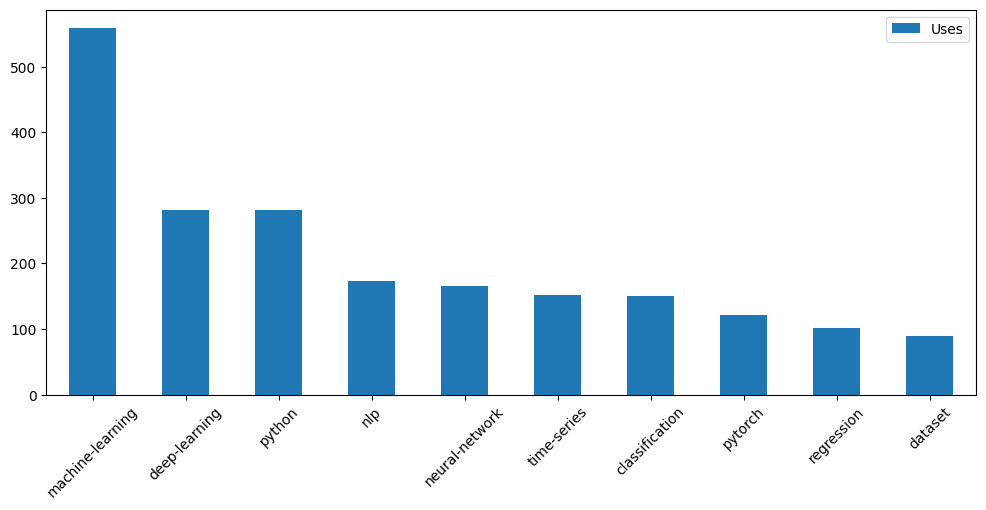

In [19]:
# Grab top 10 tags by use count
tag_uses_top_10 = tag_uses.sort_values(by='Uses', ascending=False).head(10)

# Plot top 10 tags
tag_uses_top_10.plot(kind='bar', figsize=(12,5), rot=45)